In [9]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import ot

In [10]:
from scipy.spatial.distance import cdist
from scipy.spatial.distance import euclidean
from scipy.stats import dirichlet

In [11]:
def generate_cost(X, Y, threshold, distance, barrier=1):
    """
    generate_cost given a pair of datapoints, gives a soft approximation to
    the indicator cost.
    
    :param X: first dataset of points
    :param Y: second dataset of points
    :param threshold: location of the soft threshold
    :param distance: distance function to compute pairwise distances
    :param barrier: parameter determining how hard the threshold should be
    :return: cost matrix approximating the indicator 
    """
    base_cost = cdist(X,Y, metric=distance)
    cost = np.exp(barrier*(base_cost - threshold))
    return cost

In [12]:
def solve_partial_ots(Xs, Y, Ymass, threshold, distance, barrier=1):
    """
    solve_partial_ots given a set of source distributions and a shared target
    computes the partial transport from each source to the target
    
    :param Xs: list of dataset of points
    :param Y: second dataset of points
    :param Ymass: amount of mass at each point in Y
    :param threshold: location of the soft threshold
    :param distance: distance function to compute pairwise distances
    :param barrier: parameter determining how hard the threshold should be
    :return: list of partial couplings
    """
    
    gammas = []
    for X in Xs:
        Xmass = np.ones(X.shape[0]) / X.shape[0]
        cost = generate_cost(X, Y, threshold, distance, barrier=barrier)
        gammas += [ot.partial.partial_wasserstein(Xmass, Ymass, cost, m=1, nb_dummies=10)]
        
    return gammas

In [13]:
def update_Y_locations(Xs, Y, gammas):
    """
    update_Y_locations moves the locations of the points in Y to the 
    centroids of the mass being assigned to them
    
    :param Xs: list of dataset points
    :param Y: second dataset of points to be updated
    :param gammas: partial couplings
    :return: updated locations as well as the updated mass assignments
    """
    
    # gets the amount of mass assigned to every point summed over
    # all of the classes
    total_assignment = np.sum(gammas, axis=(0,1))
    
    # shifts each point used in Y to the average of the points using it
    centroids = np.zeros(Y.shape)
    for (X,gamma) in zip(Xs, gammas):
        centroids += gamma.T @ X
    centroids /= total_assignment[:,np.newaxis] + 0.00000001
    
    # finds how much mass must be placed on each point in order that
    # Y dominates the transformed Xs
    dominating_mass = np.max(np.sum(gammas, axis=1), axis=0)
    
    # removes unused points 
    centroids = centroids[total_assignment > 0]
    dominating_mass = dominating_mass[total_assignment > 0]
    
    return centroids, dominating_mass

In [14]:
def generate_initial_Y(Xs, npoints=40):
    """
    generate_initial_Y creates a reasonable set of starting points for the 
    adversary to work from.
    
    :param Xs: list of dataset points
    :param npoints: number of support points
    """
    
    # number of classes and dimension of data
    K = len(Xs)
    d = Xs[0].shape[1]
    
    # generates random coordinates to start from
    alpha = np.ones(K)
    coords = dirichlet.rvs(alpha, size=npoints)
    
    # each point in Y is a random convex combination of real data points
    Y = np.zeros((npoints, d))
    for i in range(npoints):
        for k in range(K):
            Y[i,:] += coords[i,k] * Xs[k][np.random.randint(Xs[k].shape[0]),:]
    
    return Y

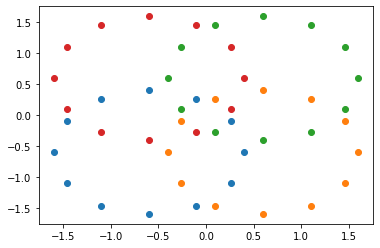

In [15]:
n = 12
linspace = np.arange(n)
circle = np.vstack([np.cos(linspace / n * 2 * np.pi), np.sin(linspace / n * 2 * np.pi)]).T
data = [
    circle + np.array([-0.6,-0.6]),
    circle + np.array([0.6,-0.6]),
    circle + np.array([0.6,0.6]),
    circle + np.array([-0.6,0.6]),
]
for d in data:
    plt.scatter(d[:,0],d[:,1])

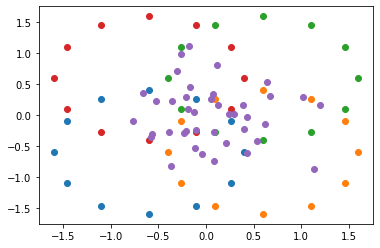

In [16]:
npoints = 40
barrier = 3

K = len(data)
Y = generate_initial_Y(data, npoints=npoints)
Ymass = np.ones(npoints) / npoints * K 

for d in data:
    plt.scatter(d[:,0],d[:,1])
plt.scatter(Y[:,0], Y[:,1])


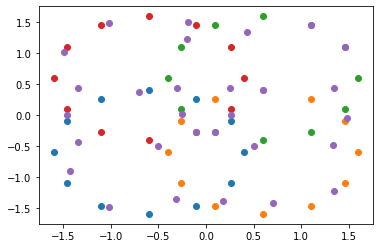

In [22]:
prev_Y = Y
gammas = solve_partial_ots(data, Y, Ymass, 1.5, euclidean, barrier=barrier)
Y,Ymass = update_Y_locations(data, Y, gammas)

for d in data:
    plt.scatter(d[:,0],d[:,1])
plt.scatter(Y[:,0], Y[:,1])